In [8]:

try:
    from tensorflow.python.compiler.tensorrt import trt_convert as trt
    print("TensorRT is available.")
except ImportError:
    print("TensorRT is not available.")


2024-11-22 17:11:14.254888: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-22 17:11:15.369262: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-22 17:11:23.282655: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:/usr/local/cuda/lib64:/usr/lib:/usr/lib/x86_64-linux-gnu:/usr/local/lib:/usr/local/cuda/lib64:/usr/lib:/usr/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-11-22 17:11:23.28

TensorRT is available.


In [9]:
%matplotlib inline

import time
import shutil
import csv

#Base inmport
import os
import io
import warnings
import json
import logging
#Quiet Mode for matplotlib
logging.getLogger('matplotlib.font_manager').disabled = True


#Math
import math
import re
import numpy as np
from scipy import stats
from IPython.display import display, JSON
import scipy.optimize as opt  # root-finding algorithm

#graph
import networkx as nx
import pydot
from graphviz import Digraph
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap  # Import the LinearSegmentedColormap class
from matplotlib import cm  # Import the predefined colormaps


#Neurmorphology and Simulation
import neuroarch.na as na
import nengo
import tensorflow as tf
import nengo_dl
from nengo.processes import Piecewise
import nengo_extras.graphviz as nxg


# ignore some efficiency warnings since this tutorial isn't designed to be
# highly optimized
warnings.simplefilter("ignore")
tf.get_logger().addFilter(lambda rec: "Tracing is expensive" not in rec.msg)
tf.get_logger().addFilter(lambda rec: "slow compared to the batch time" not in rec.msg)



2024-11-22 17:11:33.172729: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-22 17:11:35.680971: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:/usr/local/cuda/lib64:/usr/lib:/usr/lib/x86_64-linux-gnu:/usr/local/lib:/usr/local/cuda/lib64:/usr/lib:/usr/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-11-22 17:11:35.681158: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:/usr/local/cuda/lib64:/usr/lib:/usr/lib/x86_64-linux-gnu:/usr/local/lib:/usr/local/cuda/lib

In [10]:
# Create a string buffer to capture logging messages
log_buffer = io.StringIO()

# Create a stream handler that writes to the buffer
stream_handler = logging.StreamHandler(log_buffer)
stream_handler.setLevel(logging.DEBUG)  # Set the level to DEBUG to capture all types of log messages

# Create a logger
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)  # Set the level to DEBUG to capture all types of log messages

# Define a custom log format
log_format = "%(asctime)s - %(levelname)s - %(message)s"
date_format = "%Y-%m-%d %H:%M:%S"
formatter = logging.Formatter(log_format, datefmt=date_format)

# Set the formatter for both handlers
stream_handler.setFormatter(formatter)

# Add the stream handler to the logger first
logger.addHandler(stream_handler)

# Get the current working directory
current_directory = os.getcwd()

# Set the log file path
log_path = os.path.join(current_directory, "simulation.log")

# Set up logging with a file handler
file_handler = logging.FileHandler(log_path, mode='w')  # Use 'w' mode to overwrite the file
file_handler.setLevel(logging.DEBUG)  # Set the level to DEBUG for the file handler
file_handler.setFormatter(formatter)  # Apply the same formatter to the file handler
logger.addHandler(file_handler)  # Add the file handler to the logger


In [11]:
my_client = fbl.get_client()

In [12]:
data = my_client.executeNLPquery('$FB1G$')

[FBL NLP 2024-11-22 17:12:00,576] NLP successfully parsed query.


In [13]:
data = my_client.executeNLPquery('add $FB4N$')

[FBL NLP 2024-11-22 17:12:04,808] NLP successfully parsed query.


In [14]:
data = my_client.executeNLPquery('color $FB4N$ red')

[FBL NLP 2024-11-22 17:12:07,150] NLP successfully parsed query.


In [15]:
data = my_client.executeNLPquery('color $FB1G$ lime')

[FBL NLP 2024-11-22 17:12:14,051] NLP successfully parsed query.


In [16]:
# timer
start_time = time.time()

neurons = my_client.NLP_result.neurons

hashids = list(neurons.keys())
names = [neurons[k]['uname'] for k in neurons]

preSynapses = []
postSynapses = []

for i, hashid in enumerate(hashids):
    res = my_client.getInfo(hashid)
    data = res["data"]

    if "connectivity" in data:
        presyn = data["connectivity"]["pre"]["details"]
        postsyn = data["connectivity"]["post"]["details"]
        
        for syn in presyn:
            if 'segment' not in syn["uname"]:
                preSynapses.append(["pre", syn["syn_uname"], names[i], syn["uname"], syn["s_rid"], syn["number"], True])

        for syn in postsyn:
            if 'segment' not in syn["uname"]:
                postSynapses.append(["post", syn["syn_uname"], names[i], syn["uname"], syn["s_rid"], syn["number"], True])

connectivity = {"hashids": hashids, "names": names, "preSynapses": preSynapses, "postSynapses": postSynapses}

postSynNumberDict = {}
preSynNumberDict = {}

def process_synapses(synapses, synNumberDict, synType):
    for neuronName in connectivity['names']:
        singleNeuron_synNumber = []
        singleNeuron_synData = []
        for syn in synapses:
            if neuronName == syn[2]:
                singleNeuron_synNumber.append(syn[5])
                singleNeuron_synData.append([syn[3], syn[4], syn[5]])

        synZscore = stats.zscore(singleNeuron_synNumber)
        isnan = np.isnan(synZscore)

        if not np.any(isnan):
            synZmax = max(synZscore)
            print(f'\033[92m{neuronName}: {synType}SynZmax= {synZmax}\033[0m')
        else:
            for syn in synapses:
                if neuronName == syn[2]:
                    syn[6] = False
            print(f'\033[93m{neuronName} Error: Nan Value Found in array\033[0m')
            continue

        for r in range(len(singleNeuron_synData)):
            syn_uname = singleNeuron_synData[r][0]
            if 'segment' not in syn_uname:
                syn_rid = singleNeuron_synData[r][1]
                normSynZ = 1 - ((synZmax - synZscore[r]) / synZmax)
                synNumberDict[syn_rid] = [syn_uname, synZscore[r], normSynZ]

process_synapses(postSynapses, postSynNumberDict, "post")
process_synapses(preSynapses, preSynNumberDict, "pre")

numberOfNodes = len(names)

# End the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
avSynCalc_time = elapsed_time / (len(preSynapses) + len(postSynapses))
avNeuronCalc_time = elapsed_time / numberOfNodes

print ("No. of HashIDs= " + str( len(hashids)))
print ("No. of names= " + str( numberOfNodes ))
print ("No. of preSynapses= " + str( len(preSynapses)))
print ("No. of postSynapses= " + str( len(postSynapses)))
print(f"Elapsed time: {elapsed_time:.2f} seconds")
print(f"Avg. time per synapse: {avSynCalc_time:.4f} seconds")
print(f"Avg. time per neuron: {avNeuronCalc_time:.4f} seconds")

FB1G_R_1: postSynZmax= 6.385239743772796
FB1G_L_1: postSynZmax= 7.979914496755707
FB4N_R_1: postSynZmax= 6.049566787984049
FB4N_L_1: postSynZmax= 5.670596292773406
FB1G_R_1: preSynZmax= 10.156286862133477
FB1G_L_1: preSynZmax= 7.6781338425702765
FB4N_R_1: preSynZmax= 8.206394497169473
FB4N_L_1: preSynZmax= 7.436182910033069
No. of HashIDs= 4
No. of names= 4
No. of preSynapses= 2890
No. of postSynapses= 3188
Elapsed time: 90.67 seconds
Avg. time per synapse: 0.0149 seconds
Avg. time per neuron: 22.6676 seconds


In [17]:
res = my_client.getConnectivity()
nodes = dict(res.graph.nodes(data=True))
edges = list(res.graph.edges(data=True))
print("nodes:")
display(JSON(nodes))
print("edges:")
display(JSON(edges))
print("preSynNumberDict:")
display(JSON(preSynNumberDict))
print("postSynNumberDict:")
display(JSON(postSynNumberDict))

nodes:


<IPython.core.display.JSON object>

edges:


<IPython.core.display.JSON object>

preSynNumberDict:


<IPython.core.display.JSON object>

postSynNumberDict:


<IPython.core.display.JSON object>

In [18]:
#In this step we gather all the Neurotransmitter data from flywire
#This can be only done for each type 

neuroTransmitterDict = {} #we store unique list of neur type and neurotrans
flywire = na.NeuroArch("flywire",port=2424) #create connection to flywire

#Store Tau values related to their neurotransmitter
#Needs to be updated with further research
tauDict = {"acetylcholine" : 2.0,
           "glutamate"     : 10,
           "gaba"          : 5,
           "dopamine"      : 2,
           "octopamine"    : 5,
           "serotonin"     : 5
          }

#nt_query_result = query_result.gen_traversal_out(['HasData', 'NeurotransmitterData'], min_depth = 1)

#for each node in the current list
for neuronNode in nodes:
    transmitterDict = {}  #We may have many and each has a tau value. We store them here
    if nodes[neuronNode]["class"] == 'Neuron':
        #get name of neuron type
        currNeuron = nodes[neuronNode]["name"]
        #only process if type is not already in dict
        if not currNeuron in neuroTransmitterDict.keys():
            query = "select from Neuron where name matches '{}'".format(currNeuron) #dynamic sql statement
            query_result = flywire.sql_query(query)
            if len(query_result) == 0:
                print("no results for qeury '" + query + "' :assume acetylcholine")
                neuroTransmitterDict[currNeuron] = 'acetylcholine'
            else:
                flywireData = [n.out('HasData') for n in query_result.node_objs]
                transmitterList = flywireData[0][1].props['Transmitters']
                for transmitter in transmitterList:
                    transmitterDict[transmitter] = tauDict[transmitter]
                    neuroTransmitterDict[currNeuron] = transmitterDict
                    print(f"adding {currNeuron} transmitter {transmitter} with tau  {tauDict[transmitter]} ")
                #neuroTransmitterDict[currNeuron] = flywireData[0][1].props['Transmitters']

display(JSON(neuroTransmitterDict))

adding FB1G transmitter acetylcholine with tau  2.0 
adding FB4N transmitter glutamate with tau  10 


<IPython.core.display.JSON object>

In [19]:
#G = NetworkX Directional Graph -DiGraph- Creation
G = nx.DiGraph()

for e_pre in nodes:
    try:
        G.add_node(e_pre, uname = nodes[e_pre]['uname'],)
    except KeyError as e:
        print(f"key {e.args[0]} not found")
        continue
    
for edge in edges:
    try:
        G.add_edge(edge[0],edge[1])
    except KeyError as e:
        print(f"key {e.args[0]} error occured")
        continue

#adding centrality to the G node object
centralityDict = nx.betweenness_centrality(G, k=numberOfNodes, normalized=True, weight=None, endpoints=False, seed=None)

for e_pre in nodes:
    G.add_node(e_pre, centrality = centralityDict[e_pre])

In [20]:

connectivity_dict = dict(G.adjacency())

neuronConnectivity_dict = {}
neuronConnectivity_dict.clear()

#For simplicity we will also make a small dict of Neurons and their preSynaptic Partners
for parentHashID_key, childID_keys in connectivity_dict.items():
    if parentHashID_key in nodes.keys() and nodes[parentHashID_key]["class"] == 'Neuron':
        print(f'neuron {nodes[parentHashID_key]["name"]} found')
        neuronConnectivity_dict[parentHashID_key] = childID_keys
    else:
        pass


neuron FB1G found
neuron FB4N found
neuron FB1G found
neuron FB4N found


In [21]:
print("preSynNumberDict:")
display(JSON(preSynNumberDict))

print("postSynNumberDict:")
display(JSON(postSynNumberDict))

print("connectivityDict:")
display(JSON(connectivity_dict))

print("NeuronConnectivtyDict:")
print(display(JSON(neuronConnectivity_dict)))

print("neuroTransmitterDict:")
print(display(JSON(neuroTransmitterDict)))

preSynNumberDict:


<IPython.core.display.JSON object>

postSynNumberDict:


<IPython.core.display.JSON object>

connectivityDict:


<IPython.core.display.JSON object>

NeuronConnectivtyDict:


<IPython.core.display.JSON object>

None
neuroTransmitterDict:


<IPython.core.display.JSON object>

None


In [22]:
#Connection related helper functions

def calcTransWeight(pre,post):

    
    # Connection weights (adjusted for inhibitory connections)
    w_EE =  1.0
    w_II = -2.0
    w_EI =  0.1
    w_IE = -1.5
    
    if pre in neuroTransmitterDict.keys() and post in neuroTransmitterDict.keys():
        #Get the neurotransmitter text using the list function
        preNeuroTrans = list(neuroTransmitterDict[pre].keys())[0]
        postNeuroTrans = list(neuroTransmitterDict[post].keys())[0]
    else:
        return w_EE
    
    
    

    #Possible Neurotransmistters
    # acetylcholine       
    # glutamate
    # gaba
    # dopamine
    # octopamine
    # seratonin

    # Define the transfer varaible for different combinations
    combinedTransferValuesDict = {

        "acetylcholine--acetylcholine"  : w_EE,
        "acetylcholine--glutamate"      : w_EI,
        "acetylcholine--gaba"           : w_EI,
        "acetylcholine--dopamine"       : w_EE,
        "acetylcholine--octopamine"     : w_EI,
        "acetylcholine--seratonin"      : w_EI,

        "glutamate--acetylcholine"      : w_IE,
        "glutamate--glutamate"          : w_II,
        "glutamate--gaba"               : w_II,
        "glutamate--dopamine"           : w_IE,
        "glutamate--octopamine"         : w_II,
        "glutamate--seratonin"          : w_II,

        "gaba--acetylcholine"           : w_IE,
        "gaba--glutamate"               : w_II,
        "gaba--gaba"                    : w_II,
        "gaba--dopamine"                : w_IE,
        "gaba--octopamine"              : w_II,
        "gaba--seratonin"               : w_II,

        "dopamine--acetylcholine"       : w_EE,
        "dopamine--glutamate"           : w_EI,
        "dopamine--gaba"                : w_EI,
        "dopamine--dopamine"            : w_EE,
        "dopamine--octopamine"          : w_EI,
        "dopamine--seratonin"           : w_EI,

        "octopamine--acetylcholine"     : w_IE,
        "octopamine--glutamate"         : w_II,
        "octopamine--gaba"              : w_II,
        "octopamine--dopamine"          : w_IE,
        "octopamine--octopamine"        : w_II,
        "octopamine--seratonin"         : w_II,

        "seratonin--acetylcholine"      : w_IE,
        "seratonin--glutamate"          : w_II,
        "seratonin--gaba"               : w_II,
        "seratonin--dopamine"           : w_IE,
        "seratonin--octopamine"         : w_II,
        "seratonin--seratonin"          : w_II

    }
    
 
    #
    combinedValue = f"{preNeuroTrans}--{postNeuroTrans}"
    print(f"PrePost NeuroTransmiters: {combinedValue}")
    # Check if the combination exists in the constants dictionary
    if combinedValue in combinedTransferValuesDict:
        transferValue = combinedTransferValuesDict[combinedValue]
        return transferValue
    else:
        return w_EE  #Always return w_EE if there is a problem  

    
# Sigmoid transfer function
def sigmoid(x,a=1,theta=0.5):
    return (1 / (1 + np.exp(-a * (x - theta)))) - (1 / (1 + np.exp(a * theta)))


In [23]:
#Here we create a Nengo Graph that is based on ratio of Pre and Post synaptic Z ratio

#create models of our network. This is only for simulation The second model is for diplay purposes only
simModel = nengo.Network()
displayModel = nengo.Network()
#This is a dictionary for the creation of each Neuron/Ensemble
ensembleDict = {}
#Each ensembleDict will be stored in a list
ensembleConnectionList = []

#This is where we store pre and post synapse connecition information as a dict
connectionDict = {}

#Create ensembles for simulation
for singleNeuron in neuronConnectivity_dict:
    with simModel:
            ensNeuronSim = nengo.Ensemble(1, dimensions=1,label=nodes[singleNeuron]['uname'])
        #print("Ensemble created for " + str(ensNeuronSim))
        # Retrieve an ensemble by label

#Create ensembles only for Display purposes
for singleNeuron in neuronConnectivity_dict:
    with displayModel:
        ensNeuronDisplay = nengo.Ensemble(1, dimensions=1, label=nodes[singleNeuron]['uname'])
        #print("Ensemble created for " + str(ensNeuronSim))

# desired_label = nodes[singleNeuron]['uname']
# for ensemble in simModel.all_ensembles:
#     if ensemble.label == desired_label:
#         print(f"Found ensemble with label '{desired_label}'")


for parentHashID_key in connectivity_dict:
    #skip all Neurons for now
    if nodes[parentHashID_key]['class'] == 'Neuron': pass
    
    #start by clearing the neuron types
    #These are used to determine when a parent or child is a neuron, ie. NOT  a synapse
    parentType = None
    childType = None

    
    #Get all the children keys and put them in a dict
    childDict_key = connectivity_dict[parentHashID_key]
    #print(childDict_key)
    #childHashID_key = parentHahshID.get(parentHahshID, None)
    
    #For each child key
    for childHashID in childDict_key:
        #print("Parent : " + str(parentHashID_key) + " -- Child : " + str(childHashID))

        #If parent is in the postSynapaptic connection
        #This means that the child is a single neurons
        #So lets' first get postSynaptic Z score of the parent
        #If it's a postSynapse we should find it in the associated dict
        if parentHashID_key in postSynNumberDict.keys():
            #print("hash ID" + str(parentHashID_key) + " found in postsynNumberDict")
            #Get normalized Z score
            postSynZscore = postSynNumberDict[parentHashID_key][2]
            #print(str(parentHashID_key) + ': found in postSynNumberDict with Z= ' + str(postSynZscore))
            
            #we need to check if the z is negative, and convert it to a usable number like 0.1
            if postSynZscore < 0:
                postSynZscore = 0.01
                #print(str(parentHashID_key) + ': was neg and set to ' + str(postSynZscore))
            else:
                postSynZscore = math.ceil(postSynZscore * 100) / 100
                #print(str(parentHashID_key) + ': Rounded to ' + str(postSynZscore))

            #Now we need to get the presynaptic partner of the postsynapse
            #We can exclude the current neuron because it's presynaptic partner must be a different neruon
            #Using the filtered list, search each preSyn neuron for a matching synapse Hash
            excludeValue = childHashID;
            filtered_values = [possiblePrePartner for possiblePrePartner in neuronConnectivity_dict if possiblePrePartner != excludeValue]
            
            #Control the loops with this exit var
            exitLoop = False
            
            #Let's look at each Possible Neuron
            for eachNeuronHashValue in filtered_values:
                if exitLoop == True: pass
                possiblePreSynapses = neuronConnectivity_dict[eachNeuronHashValue].items()
                
                #Search all the preSyn for a match
                for possibleMatch in possiblePreSynapses:
                    if exitLoop == True: pass
                    #Check if the preSyn is in the preSynDict and matches the parentHash 
                    if possibleMatch[0] in preSynNumberDict.keys() and possibleMatch[0] == parentHashID_key :
                        #Since we found the matching preSynapse, let's store the Neuron's Hash and Zscore
                        parentPreSynNeuron = eachNeuronHashValue
                        preSynZscore = preSynNumberDict[(possibleMatch[0])][2]
                        #And now set the flag so the loop ends
                        exitLoop = True
            
            
            #we need to check if the z is negative, and convert it to a usable number like 0.1
            if preSynZscore < 0:
                preSynZscore = 0.01
            else:
                preSynZscore = math.ceil(preSynZscore * 100) / 100
                        
            
            #Get the total number of synapses for the parent hash
            numberOfSynapses = nodes[parentHashID_key]["N"]
            #print(str(parentHashID_key) + ': has ' + str(numberOfSynapses) + ' synapses')
            
            #Alpha Calculation
            alphaCalc = math.ceil(postSynZscore/preSynZscore * 100)/100
            #the gain/loss cannot be less than one: why? Nullclines calcs requre this
            if alphaCalc < 1.0: alphaCalc = alphaCalc + 1
            

            #Get Transfer Weights to use in the Nengo Connection
            transWeight = calcTransWeight( nodes[parentPreSynNeuron]['name'],
                                           nodes[childHashID]['name'] )
            
            #Get the Post synaptic neurons's tau
            for ntrans, tauVal in neuroTransmitterDict[nodes[childHashID]['name']].items():
                postSynTau = tauVal
            
            import random

            thetaMin = 2
            thetaMax = 4
            #Get a random theta between a theorecticl min and max
            random_theta = random.randint(thetaMin, thetaMax)
            
            #Begin the ensemble dict
            #We will connect all these later based on the values for each
            #Note: we only provide Post Synaptic Neuron Tau because the Nengo Connection expects that
            connectionDict = {"nPost"      : childHashID,
                            "namePost"     : nodes[childHashID]['uname'],
                            "typePost"     : nodes[childHashID]['name'],
                            "nPostZscore"  : postSynZscore,
                            
                            "nPre"         : parentPreSynNeuron ,
                            'namePre'      : nodes[parentPreSynNeuron]['uname'] ,
                            'typePre'      : nodes[parentPreSynNeuron]['name'],
                            "nPreZscore"   : preSynZscore,
                              
                            "N"            : numberOfSynapses,
                            "t"            : 2.0,
                            "tau"          : postSynTau,
                            "a"            : alphaCalc,  # Gain
                            "theta"        : random_theta,  # Threshold
                            "transWeight"  : transWeight
                           }
            
            #Add the connection information in a List
            ensembleConnectionList.append(connectionDict)

            #print(f'Ensemble Alpha Gain: postSynZ {postSynZscore} / preSyn {preSynZscore} = {alphaCalc}')

# External inputs (you can adjust these)
E_ext = 0.5
I_ext = 0.2


# Now that we have the full ensemble dict we can struct the Nengo Network Connections
#for key, singleEnsemble in ((k, v) for k, v in ensembleConnectionDict.items() if v['transf'] > 0):
for ensConnection in ensembleConnectionList:
    
    postNeuron = ensConnection["namePost"]
    #print(postNeuron)
    preNeuron  = ensConnection["namePre"]
    #print(preNeuron)
    #print(simModel.all_ensembles)
    
    connectionLable = str( str(preNeuron) + '--' + str(postNeuron))
    
    #Create a pair of Ensembles that will be connected soon
    postEnsemble = next((ensemble for ensemble in simModel.all_ensembles if ensemble.label == postNeuron), None)
    preEnsemble  = next((ensemble for ensemble in simModel.all_ensembles if ensemble.label == preNeuron), None)

    
    print(f"Connection:{connectionLable} alpha:{ensConnection['a']} Theta: {ensConnection['theta']} t:{ensConnection['t']} tau: {ensConnection['tau']} transWieght: {ensConnection['transWeight']}")
    
    #Create Simulaiton Connection
    with simModel:
        nengo.Connection(preEnsemble,
                         postEnsemble.neurons,
                         synapse=ensConnection['tau'],
                         function=lambda x: sigmoid(x, a=ensConnection['a'], theta=ensConnection['theta']),
                         transform=ensConnection['transWeight'],
                         label=connectionLable)
        #nengo.Connection(preEnsemble, postEnsemble.neurons, transform = ensConnection['transf'],label=connectionLable)

        

    #Now let's repeat this for the Display verision.
    #This is only done to get a visaul on the network. We won't use this for simulation
    #These connections use the standard decoder and would not be approrpirate 
    postEnsemble = next((ensemble for ensemble in displayModel.all_ensembles if ensemble.label == postNeuron), None)
    preEnsemble  = next((ensemble for ensemble in displayModel.all_ensembles if ensemble.label == preNeuron), None)       
    
    with displayModel:
        nengo.Connection(preEnsemble, postEnsemble, transform = ensConnection['transWeight'],label=connectionLable)
             
# # Iterate through all connections and print relevant details
# for conn in model.all_connections:
#     print(f"Connection from {conn.pre} to {conn.post}:")
#     print(f"  Transform: {conn.transform}")
#     print(f"  Synapse: {conn.synapse}")
#     print(f"  Learning rule: {conn.learning_rule}")
#     print(f"  Function: {conn.function}")

PrePost NeuroTransmiters: acetylcholine--glutamate
PrePost NeuroTransmiters: glutamate--glutamate
PrePost NeuroTransmiters: acetylcholine--glutamate
PrePost NeuroTransmiters: acetylcholine--acetylcholine
PrePost NeuroTransmiters: acetylcholine--acetylcholine
PrePost NeuroTransmiters: glutamate--acetylcholine
PrePost NeuroTransmiters: glutamate--acetylcholine
PrePost NeuroTransmiters: glutamate--acetylcholine
PrePost NeuroTransmiters: glutamate--acetylcholine
PrePost NeuroTransmiters: glutamate--glutamate
PrePost NeuroTransmiters: acetylcholine--glutamate
PrePost NeuroTransmiters: acetylcholine--glutamate
Connection:FB1G_L_1--FB4N_L_1 alpha:1.67 Theta: 4 t:2.0 tau: 10 transWieght: 0.1
Connection:FB4N_R_1--FB4N_L_1 alpha:3.0 Theta: 4 t:2.0 tau: 10 transWieght: -2.0
Connection:FB1G_R_1--FB4N_L_1 alpha:2.21 Theta: 2 t:2.0 tau: 10 transWieght: 0.1
Connection:FB1G_L_1--FB1G_R_1 alpha:1.15 Theta: 3 t:2.0 tau: 2.0 transWieght: 1.0
Connection:FB1G_R_1--FB1G_L_1 alpha:1.16 Theta: 2 t:2.0 tau: 2.

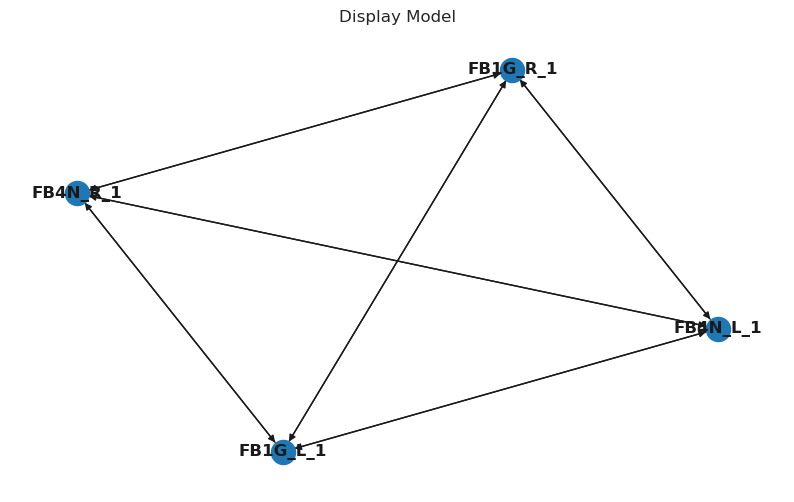

In [24]:
# Convert the Nengo model to a NetworkX graph

dot_content = ""  # Clear the existing content

#Get all the Nodes and connection from the model
dot_content = nxg.net_diagram(displayModel)
#print(dot_content)

id_to_label = {}

# Regular expression pattern to match numeric IDs and labels
pattern = r'"(\d+)" \[label="([^"]+)"\]'

# Find all matches in the .dot content
matches = re.findall(pattern, dot_content)

# Populate the dictionary with ID-label pairs
for node_id, label in matches:
    id_to_label[node_id] = label

# Now id_to_label contains the mapping of numeric IDs to labels
#print(id_to_label)

# # Replace numeric IDs with labels
# for node_id, label in id_to_label.items():
#     dot_content = dot_content.replace(node_id, label)

# Replace all occurrences of numeric IDs with labels
for node_id, label in id_to_label.items():
    dot_content = re.sub(rf'\b{re.escape(node_id)}\b', label, dot_content)

#print(dot_content)

#create the file
with open('my_model.dot', 'w') as dot_file: dot_file.write(dot_content)

# Get the current working directory
current_directory = os.getcwd()

# Specify the relative path to your .dot file (adjust as needed)
relative_path = 'my_model.dot'

# Concatenate the current directory with the relative path
read_path = os.path.join(current_directory, relative_path)

# Create a DiGraph from the parsed .dot file
nG = nx.drawing.nx_pydot.read_dot(read_path)
pos = nx.spring_layout(nG, seed=42)  # You can choose other layout algorithms

plt.figure(figsize=(10, 6))
#plt.savefig("nengoModel.svg", format="svg")

plt.title('Display Model')
nx.draw(nG, pos, with_labels=True, font_weight='bold')
#plt.show()

#Save an SVG of the diagram
#with open('nengoModel.svg', 'r') as file:
#    data = file.read()



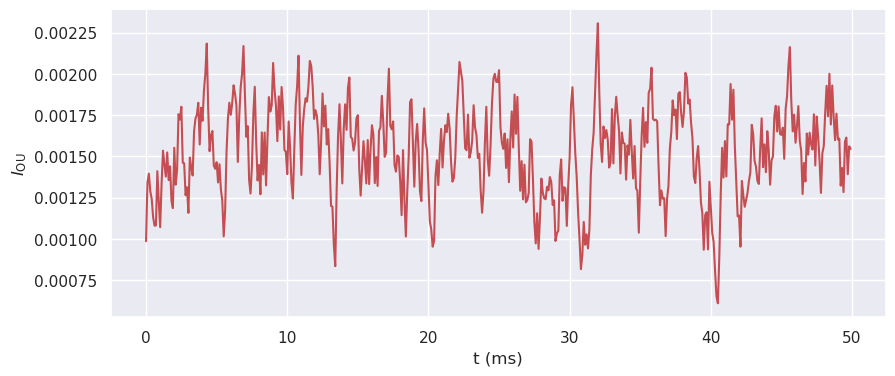

In [25]:
def default_pars_single(**kwargs):
    pars = {}

    # Excitatory parameters
    pars['tau'] = 1.     # Timescale of the E population [ms]
    pars['a'] = 2.1      # Gain of the E population
    pars['theta'] = 2  # Threshold of the E population

    # Connection strength
    pars['w'] = 1.  # E to E, we first set it to 0

    # External input
    pars['I_ext'] = 1.

    # simulation parameters
    pars['T'] = 20.       # Total duration of simulation [ms]
    pars['dt'] = .1       # Simulation time step [ms]
    pars['r_init'] = 0.2  # Initial value of E

    # External parameters if any
    pars.update(kwargs)

    # Vector of discretized time points [ms]
    pars['range_t'] = np.arange(0, pars['T'], pars['dt'])

    return pars


def my_OU(pars, sig, myseed=False):
    """
    A functions that generates Ornstein-Uhlenback process

    Args:
    pars       : parameter dictionary
    sig        : noise amplitute
    myseed     : random seed. int or boolean

    Returns:
    I          : Ornstein-Uhlenbeck input current
    """

    # Retrieve simulation parameters
    dt, range_t = pars['dt'], pars['range_t']
    Lt = range_t.size
    tau_ou = pars['tau_ou']  # [ms]

    # set random seed
    if myseed:
        np.random.seed(seed=myseed)
    else:
        np.random.seed()

    # Initialize
    #noise = np.random.randn(Lt)
    # Define the range (minimum and maximum values)
    min_value = 0.0
    max_value = 0.01
    # Generate random numbers within the specified range
    noise = np.random.uniform(min_value, max_value, size=Lt)
    
    
    I_ou = np.zeros(Lt)
    # Initialize I_ou with all values set to 0.5
    I_ou[0] = noise[0] * sig




    # generate OU
    for it in range(Lt - 1):
        I_ou[it + 1] = (I_ou[it]
            + dt / tau_ou * (0. - I_ou[it])
            + np.sqrt(2 * dt / tau_ou) * sig * noise[it + 1])

    return I_ou

pars = default_pars_single(T=50)
pars['tau_ou'] = 0.5  # [ms]
sig_ou = 0.1
I_ou = my_OU(pars, sig=sig_ou, myseed=2020)

with simModel:
    # Create an input node with your I_ou signal
    simSignal = nengo.Node(output=I_ou)


plt.figure(figsize=(10, 4))
plt.plot(pars['range_t'], I_ou, 'r')
plt.xlabel('t (ms)')
plt.ylabel(r'$I_{\mathrm{OU}}$')
plt.show()

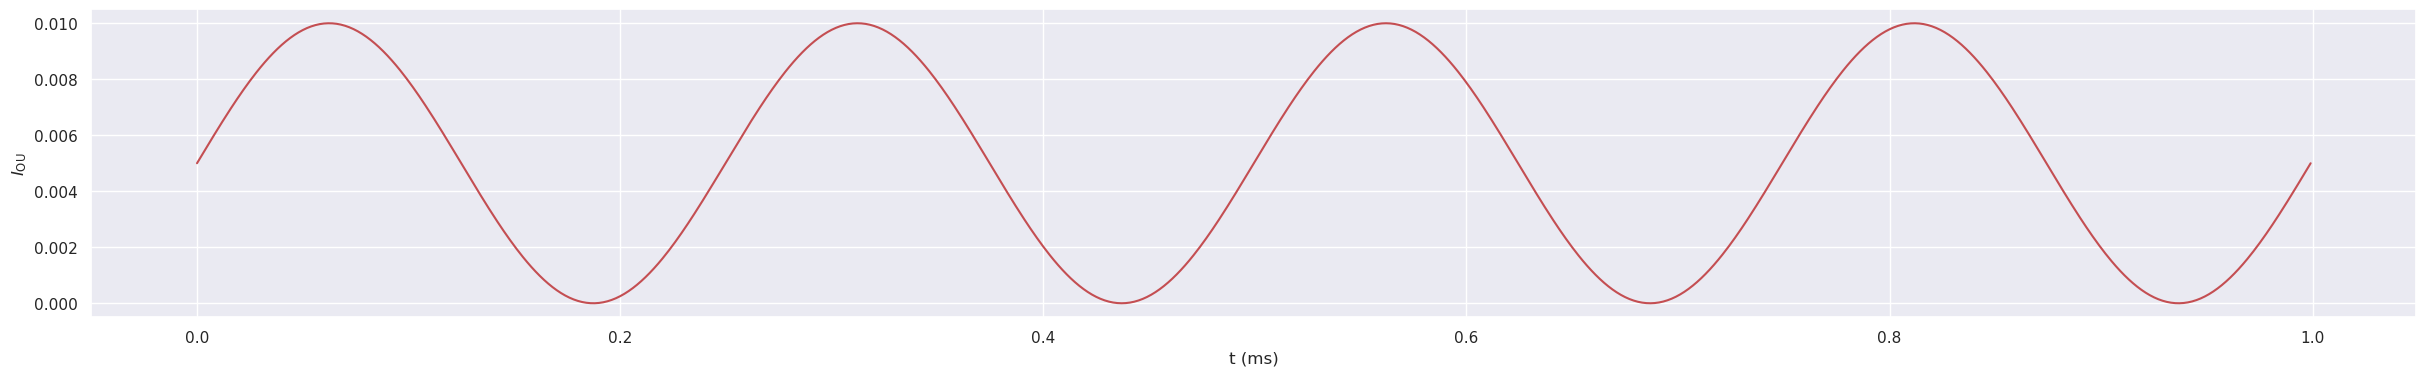

In [26]:
def generate_hz_spiking_signal(hz,pars, myseed=None):
    # Retrieve simulation parameters
    dt, range_t = pars['dt'], pars['range_t']
    Lt = range_t.size
    tau = pars['tau']  # [ms]

    # Set random seed
    if myseed:
        np.random.seed(seed=myseed)
    else:
        np.random.seed()

    # Generate a 20 Hz sine wave
    
    
    t = np.linspace(0, Lt * dt, Lt)
    frequency = hz  # Hz
    spiking_signal = np.sin(2 * np.pi * frequency * t)

    # Scale the signal to match your desired range
    min_value = 0.0
    max_value = 0.01
    spiking_signal = min_value + (max_value - min_value) * (spiking_signal - np.min(spiking_signal)) / (np.max(spiking_signal) - np.min(spiking_signal))

    return spiking_signal

# Example usage
herzRateVar = 40
pars = {'dt': 0.1, 'range_t': np.arange(0, 1, 0.001), 'tau': 0.5}
sig = 0.1  # Adjust this value as needed
spiking_signal = generate_hz_spiking_signal(herzRateVar, pars, myseed=64)  # Use a specific seed for reproducibility

with simModel:
    # Create an input node with your I_ou signal
    hzSignal = nengo.Node(output=spiking_signal)

plt.figure(figsize=(30, 4))
plt.plot(pars['range_t'], spiking_signal, 'r')
plt.xlabel('t (ms)')
plt.ylabel(r'$I_{\mathrm{OU}}$')
plt.show()


[<Ensemble 'FB1G_R_1' at 0x7fb27f053130>, <Ensemble 'FB4N_L_1' at 0x7fb28095a220>, <Ensemble 'FB1G_L_1' at 0x7fb394a34e80>, <Ensemble 'FB4N_R_1' at 0x7fb282298520>]
Ensemble with label 'FB1G_R_1' will get an input Node (key: inEnsType2).
Ensemble with label 'FB1G_R_1' will get an input Node (key: inEnsType2).
Resue Seed: 0
New Seed: 452
Using seed:452
[nengo.builder.network 2024-11-22 17:14:53,312] Network step 1: Building ensembles and nodes
[nengo.builder.network 2024-11-22 17:14:53,343] Network step 2: Building subnetworks
[nengo.builder.network 2024-11-22 17:14:53,345] Network step 3: Building connections
[nengo.builder.network 2024-11-22 17:14:53,519] Network step 4: Building probes
[nengo.builder.optimizer 2024-11-22 17:14:53,547] Optimizing model...
[nengo.builder.optimizer 2024-11-22 17:14:53,568] [views]: Reduced 85 to 85 operators in 0.006894s.
[nengo.builder.optimizer 2024-11-22 17:14:53,584] [non-views]: Reduced 85 to 78 operators in 0.013863s.
[nengo.builder.optimizer 2024

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[nengo.simulator 2024-11-22 17:14:53,742] Running <Network (unlabeled) at 0x7fb282298580>, dt=0.001000 for 0.100000 seconds, or 100 steps


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

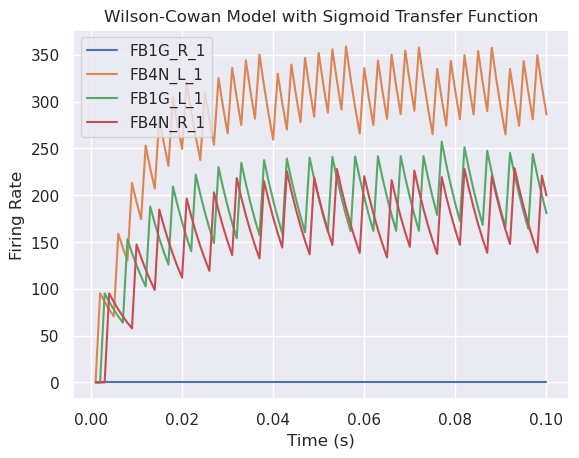

In [27]:
############################################################
#########    Main Simulation Routine    ####################
############################################################

inOutNodeTypeDict = {
    'inEnsType1': 'FB1G_L_1',
    'inEnsType2': 'FB1G_R_1'
}

outputProbeDict = {}
recorded_data_dict = {}

# Get a list of all ensembles
allSim_ensembles = simModel.ensembles
print(allSim_ensembles)

# Control our search for the in and out probe
foundInEns = False
foundOutEns = False

for oneEnsProbe in inOutNodeTypeDict:
    if foundInEns and foundOutEns: break
    # Search for the ensemble with the desired label
    for oneSimEns in allSim_ensembles:
        tempString = oneSimEns.label
        ensTypeName = re.sub(r"--.*", "", tempString)

        # Set Input Node dynamically based on dictionary keys
        if ensTypeName in inOutNodeTypeDict.values():
            matching_key = next(key for key, value in inOutNodeTypeDict.items() if value == ensTypeName)
            print(f"Ensemble with label '{ensTypeName}' will get an input Node (key: {matching_key}).")
            with simModel:
                spiking_signal_reshaped = spiking_signal.reshape(1, -1)  # Reshape to match the dimensions
                nengo.Connection(hzSignal, oneSimEns.neurons, transform=spiking_signal_reshaped)
            # Found the input ensemble, so we can break out of the loop
            foundInEns = True
            break
        else:
            print(f"Ensemble with label '{ensTypeName}' does not match any dictionary value.")
                

#Set the Out Probe
for oneSimEns in allSim_ensembles:
    with simModel:
        outputProbe = nengo.Probe(oneSimEns.neurons, synapse=0.01)
        outputProbeDict[oneSimEns.label] = outputProbe


reuse_seed = 0
#reuse_seed = 0
print(f"Resue Seed: {reuse_seed}")

# Generate a new random seed
new_seed = np.random.randint(0, 1000)  # Adjust the range as needed
print(f"New Seed: {new_seed}")

# Set the global random seed
if reuse_seed > 0:
    np.random.seed(reuse_seed)
    print(f"Using seed:{reuse_seed}")
else:
    np.random.seed(new_seed)
    print(f"Using seed:{new_seed}")

# Simulate the network
with nengo.Simulator(simModel) as sim:
    sim.run(0.1)
    
# Initialize an empty dictionary to store probe names and recorded data
recorded_data_dict = {}

    
# Plot the results
plt.figure()
for probeKey, probeInstance in outputProbeDict.items():
    recorded_data_dict[probeKey] = sim.data[probeInstance] #Store the data for later use in Phase Plane Analysis
    plt.plot(sim.trange(), sim.data[probeInstance], label=probeKey) 
plt.xlabel("Time (s)")
plt.ylabel("Firing Rate")
plt.title("Wilson-Cowan Model with Sigmoid Transfer Function")
plt.legend()
plt.show()

In [28]:
from sklearn.decomposition import PCA  
import pandas as pd

#Get the dimensions and time steps of the last simulation
allSim_ensembles = simModel.ensembles #Get a list of all ensembles
firstEnsemble = allSim_ensembles[0] #pointer to the first one
firstEnsembleOutput = sim.data[outputProbeDict[firstEnsemble.label]] #get sample dta
num_time_steps = firstEnsembleOutput.shape[0] #get the number of rows or timesteps

# Assuming num_time_steps, recorded_data_dict, and max_dimensions are defined
# Initialize the final matrix to store all reduced dimensions
# Set the maximum number of dimensions allowed for finalMatrix
max_dimensions = 2
grouped_reduced_data = {}

# Group keys by the first 4 characters of the key name
grouped_keys = {}
for key in recorded_data_dict:
    prefix = key[:4]
    if prefix not in grouped_keys:
        grouped_keys[prefix] = []
    grouped_keys[prefix].append(key)

# Process each group of keys
for prefix, keys in grouped_keys.items():
    # Initialize a temporary matrix with the appropriate size
    tempMatrix = np.zeros((num_time_steps, len(keys)))
    
    # Fill the temporary matrix with data from the probes
    for i, key in enumerate(keys):
        tempMatrix[:, i] = recorded_data_dict[key].flatten()

    #Once tempMatrix is filled out, we remove all Zero vectors because they would distort the PCA calc
    non_zero_columns = ~np.all(tempMatrix == 0, axis=0)
    tempMatrix = tempMatrix[:, non_zero_columns]
    
    # Apply PCA to reduce the data to a single dimension
    pca = PCA(n_components=1)
    reduced_data = pca.fit_transform(tempMatrix)
    
    # Add the reduced dimension to the totalMatrix
    grouped_reduced_data[prefix] = reduced_data.flatten()

print(grouped_reduced_data)
# Check the dimensions of each reduced data array in the dictionary
for key, data_array in grouped_reduced_data.items():
    if data_array.ndim > max_dimensions:
        raise Warning(f"The data array for key '{key}' exceeds the maximum allowed dimensions.")

{'FB1G': array([182.81763822, 182.81763822,  87.65505625,  96.71097326,
       104.90510582, 112.31946357, 119.02825189,  29.93603263,
        44.48464096,  57.64876615,  69.56015919,  80.33803333,
        -5.07232484,  12.80776917,  28.98634727,  43.6253301 ,
        56.87122953, -26.30596699,  -6.40522477,  11.60171144,
        27.8950611 ,  42.63789355, -39.18482198, -18.05849466,
         1.0573968 ,  18.35417067,  34.00493888, -46.99624239,
       -25.12656014,  -5.33805332,  12.5673281 ,  28.76878719,
       -51.73410836, -29.41355855,  -9.21708989,   9.05743066,
        25.59290065, -54.60776933, -32.01375453, -11.56984451,
         6.92857025,  23.6666281 , -56.35073282, -33.59085311,
       -12.99686232,   5.63735114,  22.49828473, -57.40789362,
       -34.54741175, -13.86239237,   4.85418716,  21.78964866,
       -58.04909405, -35.1275939 , -14.38736288,   4.3791742 ,
        21.35983916, -58.43800177, -35.47949216, -14.70577359,
         4.09106427,  21.09914651, -58.6738862

In [29]:
# Plotting Functions

def plot_FI_inverse(x, a, theta):
    f, ax = plt.subplots()
    ax.plot(x, F_inv(x, a=a, theta=theta))
    ax.set(xlabel="$x$", ylabel="$F^{-1}(x)$")


def plot_FI_EI(x, FI_exc, FI_inh):
    plt.figure()
    plt.plot(x, FI_exc, 'b', label='E population')
    plt.plot(x, FI_inh, 'r', label='I population')
    plt.legend(loc='lower right')
    plt.xlabel('x (a.u.)')
    plt.ylabel('F(x)')
    plt.show()


def my_test_plot(t, rE1, rI1, rE2, rI2):

    plt.figure()
    ax1 = plt.subplot(211)
    ax1.plot(pars['range_t'], rE1, 'b', label='E population')
    ax1.plot(pars['range_t'], rI1, 'r', label='I population')
    ax1.set_ylabel('Activity')
    ax1.legend(loc='best')

    ax2 = plt.subplot(212, sharex=ax1, sharey=ax1)
    ax2.plot(pars['range_t'], rE2, 'b', label='E population')
    ax2.plot(pars['range_t'], rI2, 'r', label='I population')
    ax2.set_xlabel('t (ms)')
    ax2.set_ylabel('Activity')
    ax2.legend(loc='best')

    plt.tight_layout()
    plt.show()


def plot_nullclines(Exc_null_rE, Exc_null_rI, Inh_null_rE, Inh_null_rI):

    plt.figure()
    plt.plot(Exc_null_rE, Exc_null_rI, 'b', label='E nullcline')
    plt.plot(Inh_null_rE, Inh_null_rI, 'r', label='I nullcline')
    plt.xlabel(r'$r_E$')
    plt.ylabel(r'$r_I$')
    plt.legend(loc='best')
    plt.show()


def my_plot_nullcline(pars):
    Exc_null_rE = np.linspace(-0.01, 0.96, 100)
    Exc_null_rI = get_E_nullcline(Exc_null_rE, **pars)
    Inh_null_rI = np.linspace(-.01, 0.8, 100)
    Inh_null_rE = get_I_nullcline(Inh_null_rI, **pars)

    plt.plot(Exc_null_rE, Exc_null_rI, 'b', label='E nullcline')
    plt.plot(Inh_null_rE, Inh_null_rI, 'r', label='I nullcline')
    plt.xlabel(r'$r_E$')
    plt.ylabel(r'$r_I$')
    plt.legend(loc='best')


def my_plot_vector(pars, my_n_skip=2, myscale=5):
    EI_grid = np.linspace(0., 1., 20)
    rE, rI = np.meshgrid(EI_grid, EI_grid)
    drEdt, drIdt = EIderivs(rE, rI, **pars)

    n_skip = my_n_skip

    plt.quiver(rE[::n_skip, ::n_skip], rI[::n_skip, ::n_skip],
             drEdt[::n_skip, ::n_skip], drIdt[::n_skip, ::n_skip],
             angles='xy', scale_units='xy', scale=myscale, facecolor='c')

    plt.xlabel(r'$r_E$')
    plt.ylabel(r'$r_I$')
    

def my_color_vector(pars, exclusion_radius=0.03, exclusion_point=(0.03, 0.03), my_n_skip=2, myscale=5):
    EI_grid = np.linspace(0., 1., 20)
    rE, rI = np.meshgrid(EI_grid, EI_grid)
    drEdt, drIdt = EIderivs(rE, rI, **pars)

    n_skip = my_n_skip

    # Calculate the magnitude of the vectors
    vector_magnitude = np.sqrt(drEdt**2 + drIdt**2)

    # Normalize the magnitude to [0, 1]
    normalized_magnitude = (vector_magnitude - vector_magnitude.min()) / (vector_magnitude.max() - vector_magnitude.min())

    # Use a predefined colormap (e.g., 'coolwarm') for coloring
    cmap = cm.get_cmap('coolwarm')

    tolerance = 0.02  # You can also make this flexible if needed

    # Plot the vectors with assigned colors based on normalized magnitude
    for i in range(0, rE.shape[0], n_skip):
        for j in range(0, rE.shape[1], n_skip):
            color = cmap(normalized_magnitude[i, j])
            plt.quiver(rE[i, j], rI[i, j], drEdt[i, j], drIdt[i, j],
                       angles='xy', scale_units='xy', scale=myscale, color=color)
            
            # Check if both derivatives are nearly zero (within tolerance)
            if abs(drEdt[i, j]) < tolerance and abs(drIdt[i, j]) < tolerance:
                # Exclude points within the exclusion radius around the exclusion point
                if not (abs(rE[i, j] - exclusion_point[0]) < exclusion_radius and abs(rI[i, j] - exclusion_point[1]) < exclusion_radius):
                    plt.plot(rE[i, j], rI[i, j], 'ko', ms=10, color='tomato')
                    plt.text(rE[i, j], rI[i, j] + 0.1,
                             f'Estimated Fixed Point',
                             horizontalalignment='center', verticalalignment='bottom',
                             rotation=0, color='tomato')

    plt.xlabel(r'$r_E$')
    plt.ylabel(r'$r_I$')
    
    
    

def my_plot_trajectory(pars, mycolor, x_init, mylabel):
    pars = pars.copy()
    pars['rE_init'], pars['rI_init'] = x_init[0], x_init[1]
    rE_tj, rI_tj = simulate_wc(**pars)

    plt.plot(rE_tj, rI_tj, color=mycolor, label=mylabel)
    plt.plot(x_init[0], x_init[1], 'o', color=mycolor, ms=8)
    plt.xlabel(r'$r_E$')
    plt.ylabel(r'$r_I$')


def my_plot_trajectories(pars, dx, n, mylabel):
    """
    Solve for I along the E_grid from dE/dt = 0.

    Expects:
    pars    : Parameter dictionary
    dx      : increment of initial values
    n       : n*n trjectories
    mylabel : label for legend

    Returns:
    figure of trajectory
    """
    pars = pars.copy()
    for ie in range(n):
        for ii in range(n):
            pars['rE_init'], pars['rI_init'] = dx * ie, dx * ii
            rE_tj, rI_tj = simulate_wc(**pars)
            if (ie == n-1) & (ii == n-1):
                plt.plot(rE_tj, rI_tj, 'gray', alpha=0.8, label=mylabel)
            else:
                plt.plot(rE_tj, rI_tj, 'gray', alpha=0.8)

    plt.xlabel(r'$r_E$')
    plt.ylabel(r'$r_I$')


def plot_complete_analysis(pars):
    plt.figure(figsize=(7.7, 6.))

    # plot example trajectories
    my_plot_trajectories(pars, 0.2, 6,
                       'Sample trajectories \nfor different init. conditions')
    my_plot_trajectory(pars, 'orange', [0.6, 0.8],
                     'Sample trajectory for \nlow activity')
    my_plot_trajectory(pars, 'm', [0.6, 0.6],
                     'Sample trajectory for \nhigh activity')

    # plot nullclines
    my_plot_nullcline(pars)

    # plot vector field
    EI_grid = np.linspace(0., 1., 20)
    rE, rI = np.meshgrid(EI_grid, EI_grid)
    drEdt, drIdt = EIderivs(rE, rI, **pars)
    n_skip = 2
    plt.quiver(rE[::n_skip, ::n_skip], rI[::n_skip, ::n_skip],
             drEdt[::n_skip, ::n_skip], drIdt[::n_skip, ::n_skip],
             angles='xy', scale_units='xy', scale=5., facecolor='c')

    plt.legend(loc=[1.02, 0.57], handlelength=1)
    plt.show()


# def plot_fp(x_fp, position=(0.02, 0.1), rotation=0):
#     plt.plot(x_fp[0], x_fp[1], 'ko', ms=8)
#     plt.text(x_fp[0] + position[0], x_fp[1] + position[1],
#            f'Fixed Point1=\n({x_fp[0]:.3f}, {x_fp[1]:.3f})',
#            horizontalalignment='center', verticalalignment='bottom',
#            rotation=rotation)
    
def plot_fp(x_fp, position=(0.02, 0.1), rotation=0, marker_size=8, text_color='blue', marker_color='red'):
    plt.plot(x_fp[0], x_fp[1], marker='o', color=marker_color, markersize=marker_size)  # Change the marker color
    plt.text(x_fp[0] + position[0], x_fp[1] + position[1],
             f'Fixed Point1=\n({x_fp[0]:.3f}, {x_fp[1]:.3f})',
             horizontalalignment='center', verticalalignment='bottom',
             rotation=rotation, color=text_color)
    
#Fixed Points

#Find the fixed points by checking the derivative for each point in the arrays
def my_fp(pars, rE_init, rI_init):

    tau_E, a_E, theta_E = pars['tau_E'], pars['a_E'], pars['theta_E']
    tau_I, a_I, theta_I = pars['tau_I'], pars['a_I'], pars['theta_I']
    wEE, wEI = pars['wEE'], pars['wEI']
    wIE, wII = pars['wIE'], pars['wII']
    I_ext_E, I_ext_I = pars['I_ext_E'], pars['I_ext_I']

    # define the right hand of wilson-cowan equations
    # the derivaties are checking for change using the Sigmoid F funtion
    def my_WCr(x):
        rE, rI = x
        drEdt = (-rE + F(wEE * rE - wEI * rI + I_ext_E, a_E, theta_E)) / tau_E
        drIdt = (-rI + F(wIE * rE - wII * rI + I_ext_I, a_I, theta_I)) / tau_I
        y = np.array([drEdt, drIdt])
        return y

    #Now get the array
    x0 = np.array([rE_init, rI_init])
    #Get Root of Right Hand Result
    x_fp = opt.root(my_WCr, x0).x

    return x_fp


def check_fp(pars, x_fp, mytol=1e-6):
    drEdt, drIdt = EIderivs(x_fp[0], x_fp[1], **pars)
    return drEdt**2 + drIdt**2 < mytol    


In [30]:
#Dict to determine whether a neurtrans is Ex or Inh
E_I_Dict = {"acetylcholine" : 'E',
           "glutamate"      : 'I',
           "gaba"           : 'I',
           "dopamine"       : 'E',
           "octopamine"     : 'I',
           "seratonin"      : 'I'
          }


def EIderivs(rE, rI,
    tau_E, a_E, theta_E, wEE, wEI, I_ext_E,
    tau_I, a_I, theta_I, wIE, wII, I_ext_I,
    **other_pars):

    # Compute the derivative of rE
    drEdt = (-rE + F(wEE * rE - wEI * rI + I_ext_E, a_E, theta_E)) / tau_E

    # Compute the derivative of rI
    drIdt = (-rI + F(wIE * rE - wII * rI + I_ext_I, a_I, theta_I)) / tau_I

    return drEdt, drIdt



# Define the inverse function F_inv and the function F
def F_inv(x, a, theta):

    #eps value added to avoid not taking the logarithm of zero, which should avoid runtime warning.
    # Calculate Finverse (ln(x) can be calculated as np.log(x))
    F_inverse = -1/a * np.log((x + (1 + np.exp(a * theta))**-1)**-1 - 1 ) + theta

    return F_inverse

def F(x, a, theta):
    # Define the sigmoidal transfer function f = F(x)
    #x = current in neuron, a = gain and theta is the threshold
    f = (1 + np.exp(-a * (x - theta)))**-1 - (1 + np.exp(a * theta))**-1
    return f

def get_E_nullcline(rE, a_E, theta_E, wEE, wEI, I_ext_E, **other_pars):

    # calculate rI for E nullclines on rI
    rI = 1 / wEI * (wEE * rE - F_inv(rE, a_E, theta_E) + I_ext_E)

    return rI

def get_I_nullcline(rI, a_I, theta_I, wIE, wII, I_ext_I, **other_pars):
 
    # calculate rE for I nullclines on rI
    rE = 1 / wIE * (wII * rI + F_inv(rI, a_I, theta_I) - I_ext_I)

    return rE


In [31]:
#Helper Functions

def default_pars(**kwargs):
    pars = {}

    # Excitatory parameters
    pars['tau_E'] = 1.     # Timescale of the E population [ms]
    pars['a_E'] = 1.2      # Gain of the E population
    pars['theta_E'] = 2.8  # Threshold of the E population

    # Inhibitory parameters
    pars['tau_I'] = 2.0    # Timescale of the I population [ms]
    pars['a_I'] = 1.0      # Gain of the I population
    pars['theta_I'] = 4.0  # Threshold of the I population

    # Connection strength
    pars['wEE'] = 9.   # E to E
    pars['wEI'] = 4.   # I to E
    pars['wIE'] = 13.  # E to I
    pars['wII'] = 11.  # I to I

    # External input
    pars['I_ext_E'] = 0.
    pars['I_ext_I'] = 0.

    # simulation parameters
    pars['T'] = 50.        # Total duration of simulation [ms]
    pars['dt'] = .1        # Simulation time step [ms]
    pars['rE_init'] = 0.2  # Initial value of E
    pars['rI_init'] = 0.2  # Initial value of I

    # External parameters if any
    for k in kwargs:
        pars[k] = kwargs[k]

    # Vector of discretized time points [ms]
    pars['range_t'] = np.arange(0, pars['T'], pars['dt'])
    return pars



def dF(x, a, theta):
    #Derivative of the population activation function.
    dFdx = a * np.exp(-a * (x - theta)) * (1 + np.exp(-a * (x - theta)))**-2
    return dFdx
    

PrePost NeuroTransmiters: acetylcholine--glutamate
PrePost NeuroTransmiters: glutamate--glutamate
PrePost NeuroTransmiters: acetylcholine--glutamate
PrePost NeuroTransmiters: acetylcholine--acetylcholine
PrePost NeuroTransmiters: acetylcholine--acetylcholine
PrePost NeuroTransmiters: glutamate--acetylcholine
PrePost NeuroTransmiters: glutamate--acetylcholine
PrePost NeuroTransmiters: glutamate--acetylcholine
PrePost NeuroTransmiters: glutamate--acetylcholine
PrePost NeuroTransmiters: glutamate--glutamate
PrePost NeuroTransmiters: acetylcholine--glutamate
PrePost NeuroTransmiters: acetylcholine--glutamate


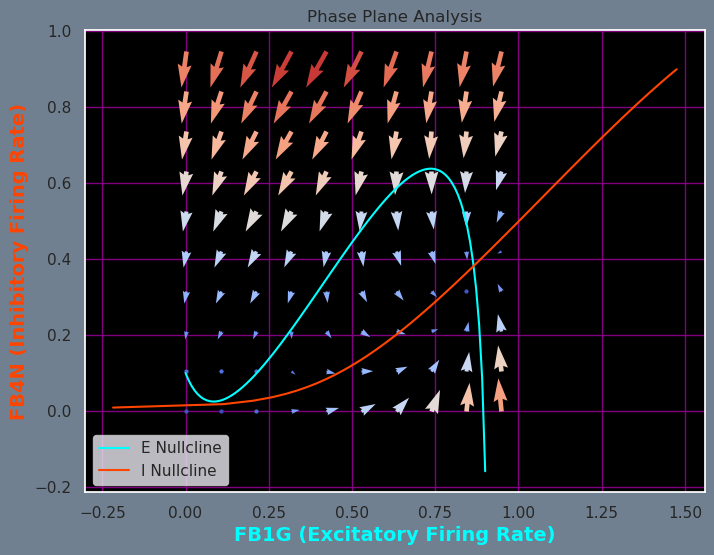

In [33]:

#Determine Which Neuron Types are E or I
#We wil use this as the base logic for Willson-Cohen below
for neuronName, simData in grouped_reduced_data.items():
    matching_neuroTransmitter = next(transmitter for neuronType, transmitter in neuroTransmitterDict.items() if neuronName == neuronType)
    neuroTrans = list(matching_neuroTransmitter.keys())[0]
    Ex_Inh = E_I_Dict[neuroTrans]
    
    if Ex_Inh == 'E': #if an inhibitory neruon
        # Extract the compacted results for excitatory and inhibitory neurons
        E_typeName = neuronName
        rE_compacted = grouped_reduced_data[neuronName]  # Get sim data for Exc vector
    elif Ex_Inh == 'I':
        I_typeName = neuronName
        rI_compacted = grouped_reduced_data[neuronName]  # Replace 'inhib' with the actual key for inhibitory neurons
    else:
        logging.warning(f"Error: Could not determine if {neuronName} is Excitetory or Inhibitory")
        

for ensConnection in ensembleConnectionList:
        #Determine Exc based parameters
        typePost = ensConnection["typePost"]
        typePre  = ensConnection["typePre"]
        
        #Determine E -> E connection perameters
        if typePre == E_typeName and typePost == E_typeName:
            #Get Transfer Weights to use in the Nengo Connection
            wEE = calcTransWeight(E_typeName,E_typeName)
            alphaCalcEE = ensConnection["a"]
            thetaEE = ensConnection["theta"] #0.5 as per sim
            postTauE = ensConnection["tau"]
        
        #Determine E -> I connection
        if typePre == E_typeName and typePost == I_typeName:
            #Get Transfer Weights to use in the Nengo Connection
            wEI = calcTransWeight(E_typeName,I_typeName )
            alphaCalcEI = ensConnection["a"]
            thetaEI = ensConnection["theta"] #0.5 as per sim
            postTauI = ensConnection["tau"]
        
        #Determine I -> E connection perameters
        if typePre == I_typeName and typePost == E_typeName:
            #Get Transfer Weights to use in the Nengo Connection
            wIE = calcTransWeight(I_typeName,E_typeName )
            alphaCalcIE = ensConnection["a"]
            thetaIE = ensConnection["theta"] #0.5 as per sim
            postTauE = ensConnection["tau"]
        
        
        #Determine I -> I connection perameters
        if typePre == I_typeName and typePost == I_typeName:
            #Get Transfer Weights to use in the Nengo Connection
            wII = calcTransWeight(I_typeName, I_typeName)
            alphaCalcII = ensConnection["a"]+1 #My alpha calculated during simulation
            thetaII = ensConnection["theta"] #0.5 as per sim
            postTauI = ensConnection["tau"]


nullclineResolution = 50.

#arbitrary - need to find logic greater constraint
pars = default_pars(T=nullclineResolution)
pars['wEE'], pars['wEI'] = 6.0, 2.0
pars['wIE'], pars['wII'] = 6.0, 2.0
pars['I_ext_E'] = 0.2
pars['I_ext_I'] = 0.2

# Excitatory parameters
#pars['tau_E'] = 1.     # Timescale of the E population [ms]
pars['a_E']     = alphaCalcEE      # Gain of the E population
pars['theta_E'] = thetaEE  # Threshold of the E population

#Inhibitory parameters
#pars['tau_I'] = 2.0    # Timescale of the I population [ms]
pars['a_I'] = alphaCalcII      # Gain of the I population
pars['theta_I'] = thetaII  # Threshold of the I population

#Connection strength
pars['wEE'] = 6.0  # E to E
pars['wEI'] = 2.0 # I to E
pars['wIE'] = 4.0  # E to I
pars['wII'] = 3.0  # I to I

#simulation parameters
pars['T'] = 100        # Total duration of simulation [ms]
pars['dt'] = .1        # Simulation time step [ms]

# Calculate the nullclines for the range of rE and rI values
nullclineResolution = pars['T']

rE_values = np.linspace(0,.9, nullclineResolution)
rI_values = np.linspace(-.01,.8, nullclineResolution)

rI_values_E_nullcline = get_E_nullcline(rE_values, **pars)
rI_values_I_nullcline = get_I_nullcline(rI_values, **pars)

# Plot the nullclines
# Create the figure with a darker grey background
fig = plt.figure(figsize=(8, 6), facecolor='slategrey')

#plot arrow vectors
#Note that this routine also can plot best fixed points within tollerance
my_color_vector(pars, exclusion_radius=0.2, exclusion_point=(0.02, 0.02), my_n_skip=2, myscale=5)

# Create xy vectors for the E nullcline
e_nullcline_points = [(rI_values_E_nullcline[i], rI_values[i]) for i in range(len(rI_values))]

# Create xy vectors for the I nullcline
i_nullcline_points = [(rI_values_I_nullcline[i], rE_values[i]) for i in range(len(rE_values))]
 
plt.plot(rE_values, rI_values_E_nullcline, label='E Nullcline',color='cyan')
plt.plot(rI_values_I_nullcline, rE_values, label='I Nullcline',color='orangered')  # Note the reversed order for plotting            
            
# Initialize an empty dictionary to store the best fixed points
best_fixed_points = {}
tolerance = 1e-3  # Set a small tolerance for comparing nullcline values

# Create xy vectors for the E nullcline
e_nullcline_points = [(rI_values_E_nullcline[i], rI_values[i]) for i in range(len(rI_values))]

# Create xy vectors for the I nullcline
i_nullcline_points = [(rI_values_I_nullcline[i], rE_values[i]) for i in range(len(rE_values))]


ax = plt.gca()
ax.grid(color='purple', linestyle='-')
ax.set_facecolor('black')  # You can choose any color you prefer

# Customize the plot
plt.xlabel(f"{E_typeName} (Excitatory Firing Rate)", fontdict={'fontsize': 14,
                                                               'fontweight': 'bold',
                                                               'color': 'cyan'})  # Set the color for the x-axis label
plt.ylabel(f"{I_typeName} (Inhibitory Firing Rate)", fontdict={'fontsize': 14,
                                                               'fontweight': 'bold',
                                                               'color': 'orangered'})  # Set the color for the x-axis label
plt.title('Phase Plane Analysis')
plt.legend()
plt.grid(True)
plt.show()